<a href="https://colab.research.google.com/github/Yash-Mawalkar/Bear_Classifier/blob/main/Final_Bear_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 13.0 MB/s 
     |████████████████████████████████| 431 kB 61.1 MB/s 
     |████████████████████████████████| 4.9 MB 56.8 MB/s 
     |████████████████████████████████| 1.3 MB 54.0 MB/s 
     |████████████████████████████████| 115 kB 61.1 MB/s 
     |████████████████████████████████| 120 kB 67.5 MB/s 
     |████████████████████████████████| 212 kB 67.5 MB/s 
     |████████████████████████████████| 127 kB 65.6 MB/s 
     |████████████████████████████████| 6.6 MB 54.4 MB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
bear_types = 'grizzly','black','teddy','panda','polar'

In [5]:
path = Path('/content/drive/MyDrive/data_1') #make sure you gave correct path

In [6]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [7]:
dls = bears.dataloaders(path)

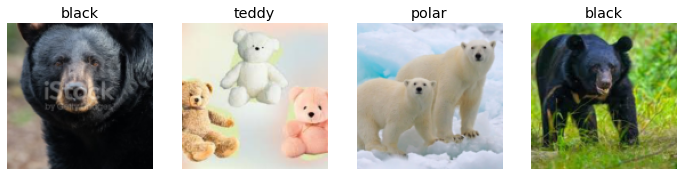

In [8]:
dls.valid.show_batch(max_n=4, nrows=1)

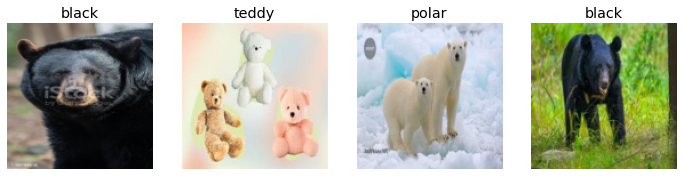

In [9]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

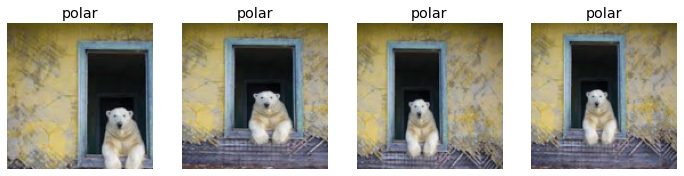

In [10]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path,bs=5)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### The batch size is by default bs = 64. If you change that value for a lower one, it will work.

## dls = bears.dataloaders(path,bs=5)


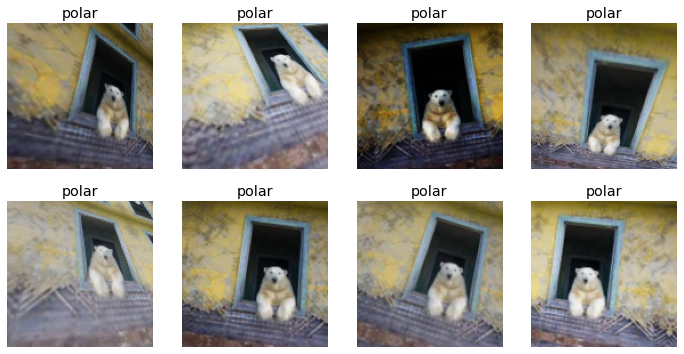

In [11]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path,bs=64)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [12]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [13]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:284: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f370

  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.223966,0.694394,0.238095,01:00


epoch,train_loss,valid_loss,error_rate,time
0,0.647859,0.197107,0.047619,00:03
1,0.445966,0.048922,0.000000,00:02
2,0.322844,0.024594,0.000000,00:03
3,0.254947,0.023564,0.000000,00:03


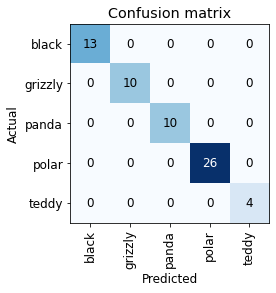

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

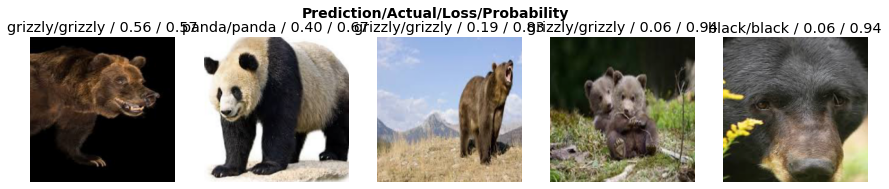

In [15]:
interp.plot_top_losses(5, nrows=1)

In [16]:
from fastai.vision.widgets import *

In [17]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [18]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [19]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [20]:
learn.export()

In [21]:
path = Path()
path.ls(file_exts='.pkl')


(#1) [Path('export.pkl')]

In [22]:
learn_inf = load_learner(path/'export.pkl')

In [23]:
learn_inf.predict('/content/drive/MyDrive/data_1/data/polar/polar_bear1.jpg')

('polar',
 TensorBase(3),
 TensorBase([9.6832e-07, 9.2984e-06, 2.5559e-05, 9.9990e-01, 6.1150e-05]))

In [24]:
learn_inf.dls.vocab

['black', 'grizzly', 'panda', 'polar', 'teddy']

## Creating a Notebook App from the Model


In [25]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [26]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['/content/drive/MyDrive/data_1/data/grizzly/grizzly25.jpg'])

In [27]:
img = PILImage.create(btn_upload.data[-1])

In [28]:
# hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [29]:
pred,pred_idx,probs = learn_inf.predict(img)

In [30]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 1.0000')

In [31]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [32]:
def on_click_classify(change):
 img = PILImage.create(btn_upload.data[-1])
 out_pl.clear_output()
 with out_pl: display(img.to_thumb(128,128))
 pred,pred_idx,probs = learn_inf.predict(img)
 lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
btn_run.on_click(on_click_classify)

In [33]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

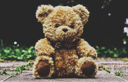

In [37]:
VBox([widgets.Label('Select your bear!'),
      btn_upload, btn_run, out_pl, lbl_pred])